In [1]:
import os
import numpy as np
import pandas as pd

from utils_notebook import get_MI_df, get_DTI_rank_df, get_loss_df
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

2024-05-10 09:28:58,665 - main - INFO - Logger is set.


# Downstream Eval

In [2]:
df = get_MI_df("ZINC", results_dir_list=["run_4"])
df_downs = get_DTI_rank_df(df, metric=f"clustering_l2_4",dataset="KIBA",order="ascending")
df


100%|██████████| 1/1 [00:00<00:00, 16.19it/s]


,X,Y,I(Y),I(Y|X),I(X->Y),I(X),Y_dim,X_dim,cond_modes,marg_modes,ff_layers,ff_hidden_dim,batch_size,I(Y->X),I(X->Y)/dim,I(Y->X)/dim
0,DenoisingPretrainingPQCMv4,ContextPred,99.895386,-16.167234,116.062620,0.0,300,256,4,4,2,512,1024,50.239949,0.386875,0.196250
1,DenoisingPretrainingPQCMv4,GPT-GNN,264.500923,110.157674,154.343249,0.0,300,256,4,4,2,512,1024,61.080045,0.514477,0.238594
2,DenoisingPretrainingPQCMv4,GraphMVP,384.809479,79.445650,305.363829,0.0,300,256,4,4,2,512,1024,87.178994,1.017879,0.340543
3,DenoisingPretrainingPQCMv4,GROVER,379.846327,106.535473,273.310854,0.0,300,256,4,4,2,512,1024,79.041889,0.911036,0.308757
4,DenoisingPretrainingPQCMv4,AttributeMask,331.514773,35.877839,295.636934,0.0,300,256,4,4,2,512,1024,66.096862,0.985456,0.258191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,ThreeDInfomax,MolR_gcn,1314.046801,319.338781,994.708020,0.0,1024,800,4,4,2,512,1024,825.262965,0.971395,1.031579
24,ThreeDInfomax,MolR_tag,1308.882363,385.024174,923.858189,0.0,1024,800,4,4,2,512,1024,842.567016,0.902205,1.053209
25,ThreeDInfomax,MoleOOD_OGB_GIN,243.215791,59.627813,183.587977,0.0,256,800,4,4,2,512,1024,513.174536,0.717141,0.641468
26,ThreeDInfomax,MoleOOD_OGB_GCN,264.184007,40.542053,223.641953,0.0,256,800,4,4,2,512,1024,576.844889,0.873601,0.721056


In [8]:
%matplotlib inline


def plot_corr(df, REMOVE_MODELS=[], FIGSIZE = 3, title="", DATASET="Kiba"):
    fig, axes = plt.subplots(2,2, figsize=(FIGSIZE*2,FIGSIZE*2), sharex=True, sharey=False)
    axes = axes.flatten()
    key = "clustering_l2_"


    for i,n_clus in enumerate([1,2,4,8]):
        if "l2" in key:
            end = "(reg)"
            df_downs = get_DTI_rank_df(df, metric=f"{key}{n_clus}",dataset=DATASET,order="ascending")
        else:
            end = "(clas)"
            df_downs = get_DTI_rank_df(df, metric=f"{key}{n_clus}")
        df_downs = df_downs[~df_downs.embedder.isin(REMOVE_MODELS)]
        df_tmp = df_downs.groupby("embedder").mean()
        sns.scatterplot(data=df_tmp, y="meanrank_metric", x="meanrank_information", hue="embedder", ax=axes[i], legend=False, style="embedder",)
        sns.regplot(data=df_tmp, y="meanrank_metric", x="meanrank_information", ax=axes[i], scatter=False, color="blue", line_kws = {"alpha":0.2})

        # Display the correlation coefficient
        corr = df_tmp[["meanrank_metric", "meanrank_information"]].corr("spearman").iloc[0,1]
        corr_kendall = df_tmp[["meanrank_metric", "meanrank_information"]].corr("kendall").iloc[0,1]
        corr_p = df_tmp[[f"{key}{n_clus}", "information"]].corr("pearson").iloc[0,1]
        axes[i].text(
            0.8,
            0.2,
             f"\nR: {corr_p:.2f}\n" + r"$\rho_s $" + f": {corr:.2f}\n " +r"$\tau $: "+f"{corr_kendall:.2f}",
            horizontalalignment='center',
            verticalalignment='center',
            transform=axes[i].transAxes
        )
        axes[i].set_title("$n_{neighbors}$ = "+f"{n_clus}")

        axes[i].set_xlabel("")

        #remove x/yticks
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    fig.supylabel(f"Local agreement rank")
    fig.supxlabel("Predictivness rank")
    fig.suptitle(title)


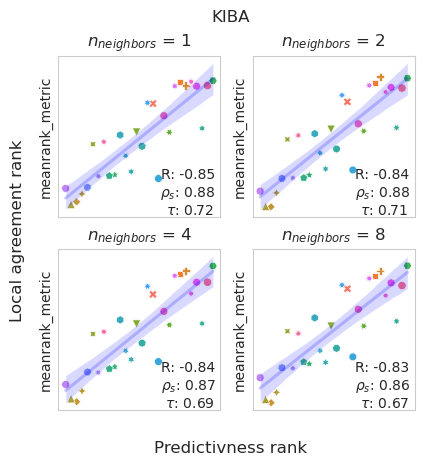

In [9]:
DATASET="KIBA"
plot_corr(df, title=f"{DATASET}", FIGSIZE=2.3, DATASET=DATASET)
from utils_notebook import LATEX_FIG_PATH

plt.savefig(f"{LATEX_FIG_PATH}/molecule/DTI_all_res_{DATASET}.pdf", format = "pdf", bbox_inches = 'tight')

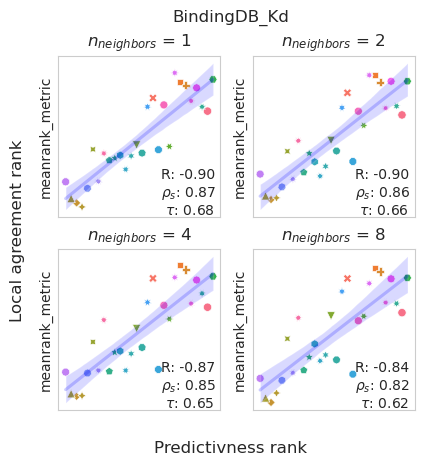

In [10]:
DATASET="BindingDB_Kd"
plot_corr(df, title=f"{DATASET}", FIGSIZE=2.3, DATASET=DATASET)
from utils_notebook import LATEX_FIG_PATH

plt.savefig(f"{LATEX_FIG_PATH}/molecule/DTI_all_res_{DATASET}.pdf", format = "pdf", bbox_inches = 'tight')

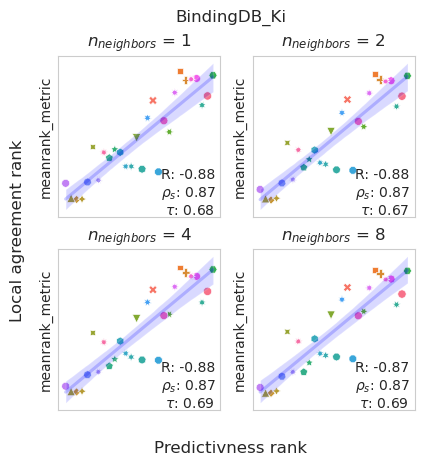

In [11]:
DATASET="BindingDB_Ki"
plot_corr(df, title=f"{DATASET}", FIGSIZE=2.3, DATASET=DATASET)
from utils_notebook import LATEX_FIG_PATH

plt.savefig(f"{LATEX_FIG_PATH}/molecule/DTI_all_res_{DATASET}.pdf", format = "pdf", bbox_inches = 'tight')

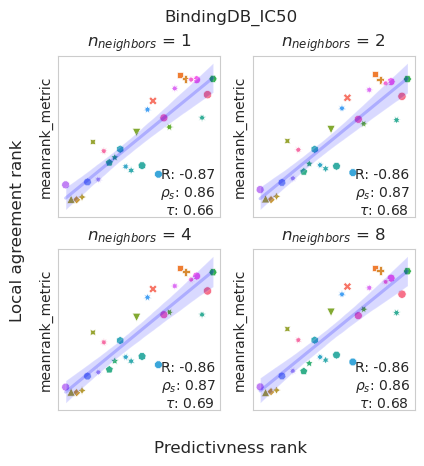

In [12]:
DATASET="BindingDB_IC50"
plot_corr(df, title=f"{DATASET}", FIGSIZE=2.3, DATASET=DATASET)
from utils_notebook import LATEX_FIG_PATH

plt.savefig(f"{LATEX_FIG_PATH}/molecule/DTI_all_res_{DATASET}.pdf", format = "pdf", bbox_inches = 'tight')

In [21]:
import pandas as pd
import numpy as np
from autorank import autorank

def compute_ranking(df_downs, dataset="Overall", type_metric="reg", n_neighb=-1):
    df_downs_linearized = []
    for col in df_downs.columns:
        if "clustering" in col:
            df_tmp = df_downs[["embedder", "dataset", "target", col]].rename(columns={col:"metric"})
            df_tmp["n_neighb"] = int(col.split("_")[-1])
            if "l2" in col:
                df_tmp["type"] = "reg"
                df_tmp.metric = 1-df_tmp.metric
            else:
                df_tmp["type"] = "cls"
            df_downs_linearized.append(df_tmp)
    df_downs_linearized = pd.concat(df_downs_linearized)

    if type_metric!="all":
        df_downs_linearized = df_downs_linearized[df_downs_linearized["type"] == type_metric]
    if n_neighb != -1:
        df_downs_linearized = df_downs_linearized[df_downs_linearized["n_neighb"] == n_neighb]

    df_to_rank = df_downs_linearized.pivot_table(index=["n_neighb", "type",  "dataset", "target"], columns="embedder", values="metric")

    res = autorank(
        df_to_rank,
        alpha=0.05,
        verbose=False,
        force_mode="nonparametric"
    ).rankdf.meanrank.to_frame()
    res = res.rename(columns={"meanrank":dataset})
    return res



def plot_golb_corr(df_downs, FIGSIZE=3, type_metric="reg", n_neighb=-1):
    res = compute_ranking(df_downs, dataset="meanrank", type_metric=type_metric, n_neighb=n_neighb)

    df_downs = df_downs.join(res, on="embedder")

    %matplotlib inline

    fig = plt.figure(figsize=(4,6))
    df_plot = df_downs
    sns.scatterplot(data=df_plot.groupby("embedder").mean().sort_values("information"), y="embedder", x="meanrank", hue="embedder", legend=False)

    corr = df_plot[["meanrank", "meanrank_information"]].corr("spearman").iloc[0,1]
    kendall = df_plot[["meanrank", "meanrank_information"]].corr("kendall").iloc[0,1]
    corr_p = df_plot[["meanrank", "meanrank_information"]].corr("pearson").iloc[0,1]
    plt.text(0.15, 0.85, r"$\rho$: " +  f"{corr:.3f}\n"+r"$\tau $: "+f"{kendall:.3f}" + f"\nR: {corr_p:.3f}",
             horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)




Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests


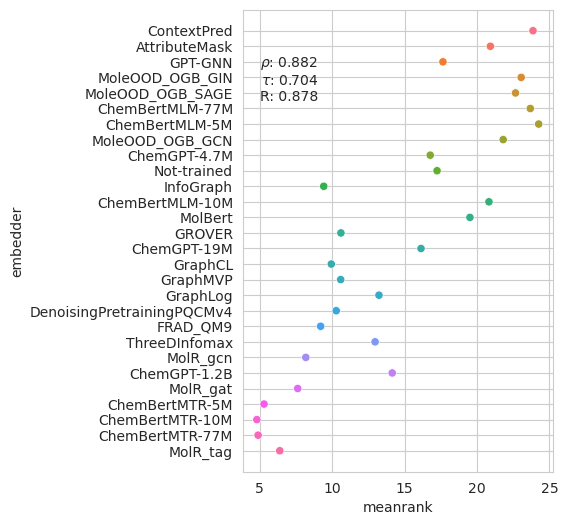

In [22]:
df_downs = pd.concat([get_DTI_rank_df(df, order="ascending", dataset=dataset) for dataset in ["BindingDB_IC50","BindingDB_Ki", "BindingDB_Kd","KIBA"]])
plot_golb_corr(df_downs, type_metric="reg", n_neighb=-1)
plt.savefig(f"{LATEX_FIG_PATH}/molecule/mearnak_detailed_global_DTI.pdf", format = "pdf", bbox_inches = 'tight')

Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests


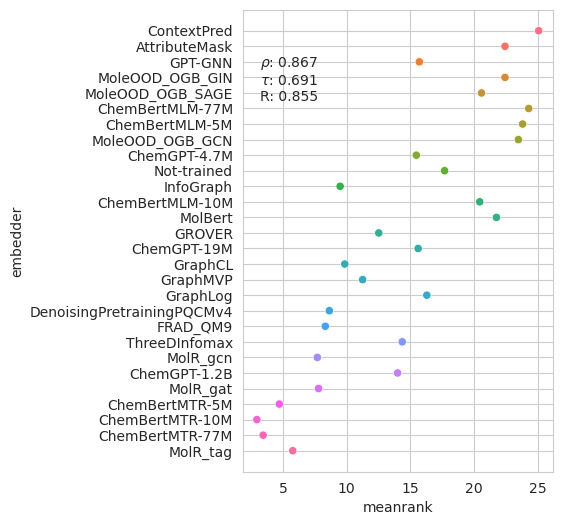

In [23]:
DATASET ="KIBA"
df_downs = get_DTI_rank_df(df, order="ascending", dataset=DATASET)
plot_golb_corr(df_downs, type_metric="reg", n_neighb=4)
plt.savefig(f"{LATEX_FIG_PATH}/molecule/mearnak_detailed_{DATASET}_DTI.pdf", format = "pdf", bbox_inches = 'tight')

Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests


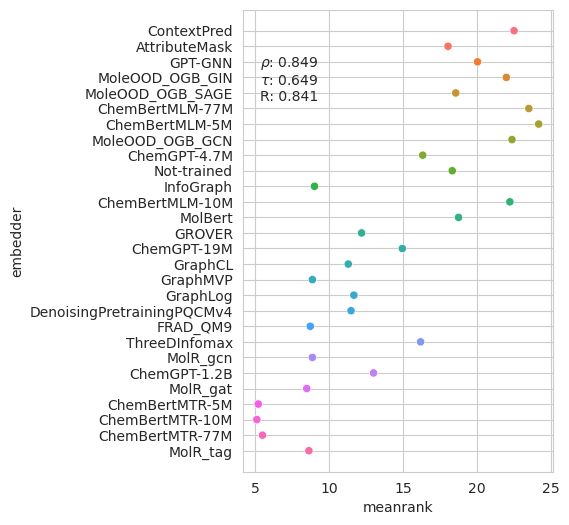

In [24]:
DATASET ="BindingDB_Kd"
df_downs = get_DTI_rank_df(df, order="ascending", dataset=DATASET)
plot_golb_corr(df_downs, type_metric="reg", n_neighb=4)
plt.savefig(f"{LATEX_FIG_PATH}/molecule/mearnak_detailed_{DATASET}_DTI.pdf", format = "pdf", bbox_inches = 'tight')

Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests


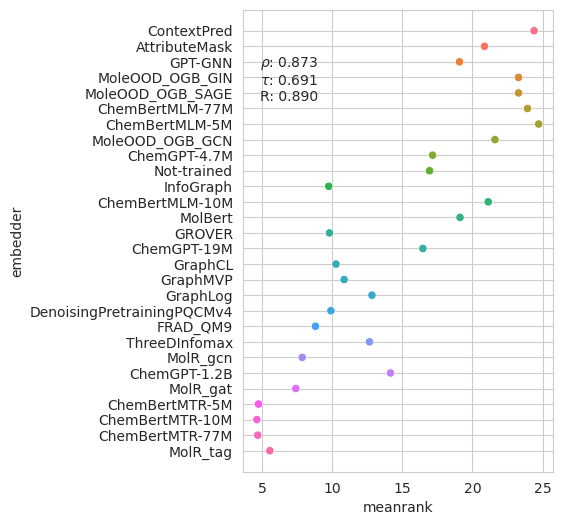

In [25]:
DATASET ="BindingDB_Ki"
df_downs = get_DTI_rank_df(df, order="ascending", dataset=DATASET)
plot_golb_corr(df_downs, type_metric="reg", n_neighb=4)
plt.savefig(f"{LATEX_FIG_PATH}/molecule/mearnak_detailed_{DATASET}_DTI.pdf", format = "pdf", bbox_inches = 'tight')

In [26]:
from autorank import autorank
df_plot = None

DATASETS = ["BindingDB_IC50","BindingDB_Ki", "BindingDB_Kd","KIBA"]

for dataset in DATASETS:
    df_downs = get_DTI_rank_df(df, order="ascending", dataset=dataset)
    res = compute_ranking(df_downs, dataset)
    if df_plot is None:
        df_plot = res
    else:
        df_plot = df_plot.join(res)


df_downs =  pd.concat(
    [
        get_DTI_rank_df(
            df, order="ascending", dataset=dataset
        ) for dataset in DATASETS
    ]
)
res = compute_ranking(df_downs)
df_plot = df_plot.join(res)
df_downs = df_downs.groupby("embedder").mean().rename(columns={"meanrank_information":"Predictivness"})[['Predictivness']]

df_plot = df_plot.join(df_downs)

Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests


In [28]:
avg_results = df_plot.reset_index().rename(columns={"embedder":"model"})

def prerpocess_emb_name(x):
    return x.replace(
        "DenoisingPretrainingPQCMv4",
        "3D-denoising"
    ).replace(
        "Chem",
        ""
    ).replace(
        "ThreeDInfomax",
        "3D-Infomax"
    ).replace(
        "_OGB",
        ""
    )

avg_results.model = avg_results.model.apply(prerpocess_emb_name)
avg_results

,model,BindingDB_IC50,BindingDB_Ki,BindingDB_Kd,KIBA,Overall,Predictivness
0,BertMLM-5M,24.322354,24.420822,23.380952,23.654286,24.255275,22.0
1,BertMLM-77M,23.682775,23.534704,22.714286,24.071429,23.677914,23.0
2,ContextPred,23.668332,24.067722,22.464286,24.621429,23.862358,28.0
3,MoleOOD_GIN,23.105427,23.150606,22.023810,22.650000,23.048058,25.0
4,MoleOOD_SAGE,22.758099,23.080526,18.928571,21.664286,22.656145,24.0
5,MoleOOD_GCN,21.691685,21.389825,22.654762,23.182857,21.805007,21.0
6,BertMLM-10M,20.875540,20.764488,21.357143,20.602857,20.822756,17.0
7,AttributeMask,20.768494,20.713949,17.857143,22.541429,20.921802,27.0
8,MolBert,19.514984,18.634771,19.202381,21.387143,19.511303,16.0
9,GPT-GNN,17.341388,19.110175,19.142857,16.002857,17.649364,26.0


In [29]:
# make mosaic map
%matplotlib inline

def plot_glob_mosaic(avg_results, METRIC=METRIC, MODEL_TO_ANNOATE = set(["3D-Infomax", "InfoGraph", "MolBert", "BertMTR-5M", "GraphCL", "Not-trained"]), MODEL_TO_ANNOATE_left = set(), FIGSIZE=5):
    mosaic_map = [
        ['A', 'A', 'B', 'C'],
        ['A', 'A', 'D', 'E'],
    ]

    mosaic_to_task_map = {
        'A': 'Overall',
        'B': 'BindingDB_Kd',
        'C': 'BindingDB_Ki',
        'D': 'BindingDB_IC50',
        'E': 'KIBA',
    }

    mosaic_map = np.array(mosaic_map)
    mosaic_map = np.vectorize(lambda x: mosaic_to_task_map[x])(mosaic_map)



    fig, ax = plt.subplot_mosaic(mosaic_map, figsize=(FIGSIZE, FIGSIZE * 2/3), gridspec_kw={"width_ratios": [1,1, 1, 1],})
    METRICS = mosaic_to_task_map.values()
    METRIC= "Predictivness"
    for i, metric in enumerate(METRICS):
        if metric == "Overall":
            s = 100
        else:
            s = 50
        ax[metric] = sns.regplot(data=avg_results, y=METRIC, x=metric, ax=ax[metric], scatter=False)
        ax[metric] = sns.scatterplot(data=avg_results, y=METRIC, x=metric, ax=ax[metric], legend=False, hue = 'model', style='model', s=s)


        # annotate model names
        if metric == 'Overall':
            for i, row in avg_results.iterrows():
                xy = (row[metric], row[METRIC])
                if row['model'] in MODEL_TO_ANNOATE:
                    xytext = (9.5,-9.5)
                    ax[metric].annotate(
                        row['model'],
                        xy,
                        fontsize=10,
                        va='center',
                        ha='left',
                        textcoords='offset points',
                        xytext=xytext,
                        arrowprops=dict(
                            facecolor='black',
                            color='black',
                            arrowstyle='->',
                            connectionstyle='arc3,rad=0.2'
                        )
                    )
                elif row["model"] in MODEL_TO_ANNOATE_left:
                    xytext = (-65.5,10.5)
                    ax[metric].annotate(
                        row['model'],
                        xy,
                        fontsize=10,
                        va='center',
                        ha='left',
                        textcoords='offset points',
                        xytext=xytext,
                        arrowprops=dict(
                            facecolor='black',
                            color='black',
                            arrowstyle='->',
                            connectionstyle='arc3,rad=0.2'
                        )
                    )

        # annotate correllation
        corr = avg_results[[METRIC, metric]].corr(method="spearman").iloc[0, 1]
        kendall = avg_results[[METRIC, metric]].corr(method="kendall").iloc[0, 1]
        #pearson = avg_results[[METRIC, metric]].corr(method="pearson").iloc[0, 1]
        if metric != 'Overall':
            ax[metric].annotate(
                r"$\rho_s$" + f": {corr:.2f}\n" + r" $\tau$" + f": {kendall:.2f}",
                (0.55, 0.05),
                xycoords='axes fraction',
                fontsize=8,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'),
            )
        else:
            ax[metric].annotate(
                r"$\rho_s$" + f": {corr:.2f}\n" + r" $\tau$" + f": {kendall:.2f}",
                (0.75, 0.1),
                xycoords='axes fraction',
                fontsize=12,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'),
            )

        if metric == 'Overall':
            ax[metric].set_title(metric, fontweight='bold')
            ax[metric].set_ylabel(METRIC + "  " + r"$(rank\downarrow)$")
            ax[metric].set_xlabel('Downstream tasks  $(rank\downarrow)$')
        else:
            ax[metric].set_title(metric.replace('Average', '').replace("(", "\n("), fontsize=10,)
            ax[metric].set_xlabel('')
            ax[metric].set_ylabel('')
            ax[metric].set_xticks([])
            ax[metric].set_yticks([])


    fig.tight_layout()

    plt.savefig(f"{LATEX_FIG_PATH}/molecule/meanrank_DTI_all.pdf", format = "pdf", bbox_inches = 'tight')


NameError: name 'METRIC' is not defined

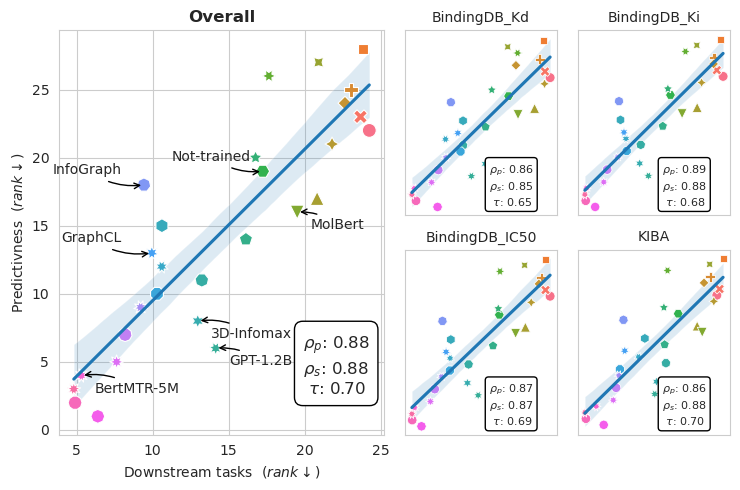

In [38]:

plot_glob_mosaic(
    avg_results,
    METRIC="Predictivness",
    MODEL_TO_ANNOATE = set(["3D-Infomax", "GPT-1.2B", "MolBert", "BertMTR-5M",]),
    MODEL_TO_ANNOATE_left = set(["GraphCL", "Not-trained", "InfoGraph"]),
    FIGSIZE=7.5
)

In [95]:
df_downs =  pd.concat(
    [
        get_DTI_rank_df(
            df, order="ascending", dataset=dataset
        ) for dataset in ["BindingDB_Ki", "BindingDB_Kd","KIBA"]
    ]
)

Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
